In [1]:
import pandas as pd
import statistics as stat
import numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from numpy import asarray
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay as cmd
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv("matchup_stats.csv")

In [3]:
df

,gmDate,teamAbbr,teamDayOff,avg_poss,Off_Eff,Def_Eff,Net_Eff,Prev_EFG,Prev_TS,Prev_3Ppct,...,away_L10_TOP48,away_L10_ATORatio,away_L10_Win_Pct,away_L10_Opp_EFG,away_L10_Opp_TS,away_L10_SP48,away_L10_BP48,Line,MOV,Cover?
0,2012-10-30,CLE,0,88.940900,105.688200,94.444700,11.243500,0.500000,0.529995,0.350000,...,13.000000,2.000000,0.0,0.500000,0.529995,11.000000,10.000000,-6.0,10,Yes
1,2012-10-30,MIA,0,94.983200,126.338100,112.651500,13.686600,0.594937,0.644607,0.500000,...,16.000000,1.500000,0.0,0.594937,0.644607,4.000000,2.000000,-6.5,13,Yes
2,2012-10-30,LAL,0,91.579000,99.367800,108.103400,-8.735600,0.512987,0.501986,0.230769,...,12.000000,1.833333,0.0,0.512987,0.501986,9.000000,5.000000,-8.5,-8,No
3,2012-10-31,PHI,0,94.371500,89.009900,79.473100,9.536800,0.394118,0.445671,0.280000,...,22.000000,0.863636,0.0,0.394118,0.445671,9.000000,5.000000,2.0,9,Yes
4,2012-10-31,TOR,0,91.564100,96.107500,98.291800,-2.184300,0.395604,0.442834,0.352941,...,19.000000,1.157895,0.0,0.395604,0.442834,3.000000,10.000000,1.5,-2,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7372,2018-04-11,ORL,2,98.320457,105.166778,110.320910,-5.154132,0.512067,0.544915,0.350190,...,15.480649,1.806452,0.3,0.542169,0.572646,7.290886,4.494382,6.0,9,Yes
7373,2018-04-11,PHI,1,100.298523,109.350380,105.228548,4.121832,0.534821,0.568240,0.367787,...,11.721612,2.191667,0.7,0.526316,0.565775,9.963370,5.274725,-6.0,35,Yes
7374,2018-04-11,LAC,2,98.772383,110.493546,110.357602,0.135943,0.527256,0.564630,0.353994,...,14.987755,1.549020,0.3,0.497805,0.529303,6.073469,4.114286,-2.5,-15,No
7375,2018-04-11,POR,2,96.857905,109.138401,106.588472,2.549930,0.511004,0.549319,0.366185,...,14.647423,1.871622,0.8,0.494118,0.532017,8.313402,5.740206,-2.0,9,Yes


In [4]:
len(df[df['Cover?'] == 'Push'])

125

I dropped push results for 2 reasons:
1. Keep it a binary classification model 
2. It's not particularly useful to predict push results as a misclassification of a push does not hurt model performance. If we predict home team to cover and it is a push, we do not lose any money.
3. Pushes occur at such a low frequency (~1.7% of results) that it creates a big imbalance in our dataset and it is ok to ignore for now.

In [5]:
df = df[df['Cover?'] != 'Push']

In [6]:
df

,gmDate,teamAbbr,teamDayOff,avg_poss,Off_Eff,Def_Eff,Net_Eff,Prev_EFG,Prev_TS,Prev_3Ppct,...,away_L10_TOP48,away_L10_ATORatio,away_L10_Win_Pct,away_L10_Opp_EFG,away_L10_Opp_TS,away_L10_SP48,away_L10_BP48,Line,MOV,Cover?
0,2012-10-30,CLE,0,88.940900,105.688200,94.444700,11.243500,0.500000,0.529995,0.350000,...,13.000000,2.000000,0.0,0.500000,0.529995,11.000000,10.000000,-6.0,10,Yes
1,2012-10-30,MIA,0,94.983200,126.338100,112.651500,13.686600,0.594937,0.644607,0.500000,...,16.000000,1.500000,0.0,0.594937,0.644607,4.000000,2.000000,-6.5,13,Yes
2,2012-10-30,LAL,0,91.579000,99.367800,108.103400,-8.735600,0.512987,0.501986,0.230769,...,12.000000,1.833333,0.0,0.512987,0.501986,9.000000,5.000000,-8.5,-8,No
3,2012-10-31,PHI,0,94.371500,89.009900,79.473100,9.536800,0.394118,0.445671,0.280000,...,22.000000,0.863636,0.0,0.394118,0.445671,9.000000,5.000000,2.0,9,Yes
4,2012-10-31,TOR,0,91.564100,96.107500,98.291800,-2.184300,0.395604,0.442834,0.352941,...,19.000000,1.157895,0.0,0.395604,0.442834,3.000000,10.000000,1.5,-2,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7372,2018-04-11,ORL,2,98.320457,105.166778,110.320910,-5.154132,0.512067,0.544915,0.350190,...,15.480649,1.806452,0.3,0.542169,0.572646,7.290886,4.494382,6.0,9,Yes
7373,2018-04-11,PHI,1,100.298523,109.350380,105.228548,4.121832,0.534821,0.568240,0.367787,...,11.721612,2.191667,0.7,0.526316,0.565775,9.963370,5.274725,-6.0,35,Yes
7374,2018-04-11,LAC,2,98.772383,110.493546,110.357602,0.135943,0.527256,0.564630,0.353994,...,14.987755,1.549020,0.3,0.497805,0.529303,6.073469,4.114286,-2.5,-15,No
7375,2018-04-11,POR,2,96.857905,109.138401,106.588472,2.549930,0.511004,0.549319,0.366185,...,14.647423,1.871622,0.8,0.494118,0.532017,8.313402,5.740206,-2.0,9,Yes


In [7]:
df = df.rename(columns = {'teamAbbr':'Home', 'away_teamAbbr': 'Away'})

I one-hot-encoded the categorical variables for use with Random Forest

In [8]:
categories = ['Home','Away','Official1','Official2','Official3']

In [9]:
ohe = OneHotEncoder()
for i in categories:
    transformed = ohe.fit_transform(df[[i]])
    col_names = [i + '_' + j for j in ohe.categories_[0]]
    df[col_names] = transformed.toarray()

In [10]:
df

,gmDate,Home,teamDayOff,avg_poss,Off_Eff,Def_Eff,Net_Eff,Prev_EFG,Prev_TS,Prev_3Ppct,...,Official3_Steven Anderson,Official3_Tom Washington,Official3_Tony Brothers,Official3_Tony Brown,Official3_Tre Maddox,Official3_Tyler Ford,Official3_Violet Palmer,Official3_Vladimir Voyard-Tadal,Official3_Zach Zarba,Official3_nan nan
0,2012-10-30,CLE,0,88.940900,105.688200,94.444700,11.243500,0.500000,0.529995,0.350000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2012-10-30,MIA,0,94.983200,126.338100,112.651500,13.686600,0.594937,0.644607,0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2012-10-30,LAL,0,91.579000,99.367800,108.103400,-8.735600,0.512987,0.501986,0.230769,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2012-10-31,PHI,0,94.371500,89.009900,79.473100,9.536800,0.394118,0.445671,0.280000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2012-10-31,TOR,0,91.564100,96.107500,98.291800,-2.184300,0.395604,0.442834,0.352941,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7372,2018-04-11,ORL,2,98.320457,105.166778,110.320910,-5.154132,0.512067,0.544915,0.350190,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7373,2018-04-11,PHI,1,100.298523,109.350380,105.228548,4.121832,0.534821,0.568240,0.367787,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7374,2018-04-11,LAC,2,98.772383,110.493546,110.357602,0.135943,0.527256,0.564630,0.353994,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7375,2018-04-11,POR,2,96.857905,109.138401,106.588472,2.549930,0.511004,0.549319,0.366185,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
df = df.drop(['gmDate','MOV', 'Home','Away','Official1','Official2','Official3'], axis = 1)

In [12]:
col = df.pop('Cover?')
df.insert(379,col.name,col)

In [13]:
list(df.dtypes)

[dtype('int64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('int64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'

In [14]:
df['Cover?'].unique()

array(['Yes', 'No'], dtype=object)

In [15]:
df['Cover?'] = np.where(df['Cover?'] == 'Yes', 1, 0)

In [16]:
df['Cover?'] = df['Cover?'].astype('int')

In [17]:
df.head(15)

,teamDayOff,avg_poss,Off_Eff,Def_Eff,Net_Eff,Prev_EFG,Prev_TS,Prev_3Ppct,Prev_3PAP48,Prev_FTpct,...,Official3_Tom Washington,Official3_Tony Brothers,Official3_Tony Brown,Official3_Tre Maddox,Official3_Tyler Ford,Official3_Violet Palmer,Official3_Vladimir Voyard-Tadal,Official3_Zach Zarba,Official3_nan nan,Cover?
0,0,88.9409,105.6882,94.4447,11.2435,0.500000,0.529995,0.350000,20.0,0.681818,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0,94.9832,126.3381,112.6515,13.6866,0.594937,0.644607,0.500000,16.0,0.812500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0,91.5790,99.3678,108.1034,-8.7356,0.512987,0.501986,0.230769,13.0,0.387097,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0,94.3715,89.0099,79.4731,9.5368,0.394118,0.445671,0.280000,25.0,0.809524,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0,91.5641,96.1075,98.2918,-2.1843,0.395604,0.442834,0.352941,17.0,0.842105,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,0,94.5665,101.5159,111.0330,-9.5171,0.481013,0.530739,0.375000,16.0,0.769231,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,0,95.9443,96.9312,90.6776,6.2536,0.430380,0.497220,0.222222,9.0,0.757576,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,0,95.0333,99.9650,104.1740,-4.2090,0.462500,0.527075,0.235294,17.0,0.913043,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8,0,100.4758,112.4649,93.5549,18.9100,0.460674,0.525679,0.428571,14.0,0.738095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
9,0,93.7904,90.6276,92.7600,-2.1324,0.425000,0.473907,0.190476,21.0,0.772727,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [18]:
x = df.drop('Cover?', axis = 1)
y = df['Cover?']

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, random_state = 1)
x_train.shape, x_test.shape

((5801, 379), (1451, 379))

In [20]:
y_train.shape, y_test.shape

((5801,), (1451,))

In [23]:
xgb = XGBClassifier(eta = 0.1, use_label_encoder = False, eval_metric = 'logloss')

In [24]:
xgb.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.1, eval_metric='logloss', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.100000001, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

In [109]:
preds = xgb.predict(x_test)

In [110]:
np.unique(preds)

array([0, 1])

In [111]:
cm = confusion_matrix(y_test, preds, labels = xgb.classes_)

<function matplotlib.pyplot.show(close=None, block=None)>

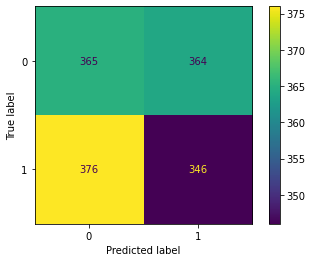

In [112]:
disp = cmd(confusion_matrix = cm, display_labels = xgb.classes_)
disp.plot()
plt.show

In [113]:
accuracy_score(y_test, preds)

0.4900068917987595

In [25]:
xgb = XGBClassifier(eta = 1, use_label_encoder = False, eval_metric = 'logloss')

In [26]:
params = {
    'gamma': [0,1,2,10],
    'max_depth': [10,20,30,40],
    'subsample': [0.5,0.75,1],
    'lambda': [0,1,10],
    'alpha': [0, 1, 10]
}

In [27]:
grid_search = GridSearchCV(estimator = xgb, param_grid = params, n_jobs = -1, verbose = 2, scoring = 'accuracy')

In [28]:
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END alpha=0, gamma=0, lambda=0, max_depth=10, subsample=0.5; total time=  28.6s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=10, subsample=0.75; total time=  35.6s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=10, subsample=1; total time=  38.1s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=10, subsample=1; total time=  37.4s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=20, subsample=0.5; total time=  26.2s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=20, subsample=0.75; total time=  36.2s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=20, subsample=1; total time=  41.6s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=30, subsample=0.5; total time=  31.1s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=30, subsample=0.5; total time=  28.8s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=30, subsample=0.75; total time=  37.2s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=30, subsample=1; total time=  42.2s
[CV] E

[CV] END alpha=0, gamma=0, lambda=0, max_depth=10, subsample=0.5; total time=  28.5s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=10, subsample=0.75; total time=  35.6s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=10, subsample=0.75; total time=  37.0s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=10, subsample=1; total time=  37.3s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=20, subsample=0.5; total time=  27.6s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=20, subsample=0.75; total time=  36.5s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=20, subsample=1; total time=  42.0s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=30, subsample=0.5; total time=  30.5s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=30, subsample=0.5; total time=  29.5s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=30, subsample=0.75; total time=  38.0s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=30, subsample=1; total time=  42.4s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=40, subsample=0.5; t

[CV] END alpha=0, gamma=0, lambda=0, max_depth=10, subsample=0.5; total time=  27.7s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=10, subsample=0.5; total time=  28.2s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=10, subsample=0.75; total time=  35.7s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=10, subsample=1; total time=  39.0s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=20, subsample=0.5; total time=  26.4s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=20, subsample=0.75; total time=  37.1s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=20, subsample=0.75; total time=  38.1s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=20, subsample=1; total time=  40.1s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=30, subsample=0.5; total time=  29.1s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=30, subsample=0.75; total time=  37.6s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=30, subsample=1; total time=  42.5s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=30, subsample=1; tot

[CV] END alpha=0, gamma=0, lambda=0, max_depth=10, subsample=0.5; total time=  28.6s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=10, subsample=0.75; total time=  36.1s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=10, subsample=1; total time=  38.8s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=20, subsample=0.5; total time=  29.3s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=20, subsample=0.5; total time=  26.6s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=20, subsample=0.75; total time=  37.4s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=20, subsample=1; total time=  40.6s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=20, subsample=1; total time=  38.8s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=30, subsample=0.75; total time=  36.4s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=30, subsample=0.75; total time=  37.3s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=30, subsample=1; total time=  43.3s
[CV] END alpha=0, gamma=0, lambda=0, max_depth=40, subsample=0.5; tot

[CV] END alpha=1, gamma=0, lambda=0, max_depth=40, subsample=0.5; total time=  33.1s
[CV] END alpha=1, gamma=0, lambda=0, max_depth=40, subsample=0.75; total time=  35.8s
[CV] END alpha=1, gamma=0, lambda=0, max_depth=40, subsample=0.75; total time=  44.1s
[CV] END alpha=1, gamma=0, lambda=0, max_depth=40, subsample=1; total time=  30.7s
[CV] END alpha=1, gamma=0, lambda=1, max_depth=10, subsample=0.5; total time=  31.2s
[CV] END alpha=1, gamma=0, lambda=1, max_depth=10, subsample=0.75; total time=  38.8s
[CV] END alpha=1, gamma=0, lambda=1, max_depth=10, subsample=1; total time=  31.2s
[CV] END alpha=1, gamma=0, lambda=1, max_depth=10, subsample=1; total time=  32.3s
[CV] END alpha=1, gamma=0, lambda=1, max_depth=20, subsample=0.5; total time=  33.7s
[CV] END alpha=1, gamma=0, lambda=1, max_depth=20, subsample=0.75; total time=  42.1s
[CV] END alpha=1, gamma=0, lambda=1, max_depth=20, subsample=1; total time=  33.6s
[CV] END alpha=1, gamma=0, lambda=1, max_depth=30, subsample=0.5; tot

[CV] END alpha=1, gamma=0, lambda=0, max_depth=40, subsample=0.75; total time=  42.4s
[CV] END alpha=1, gamma=0, lambda=0, max_depth=40, subsample=1; total time=  31.8s
[CV] END alpha=1, gamma=0, lambda=1, max_depth=10, subsample=0.5; total time=  31.3s
[CV] END alpha=1, gamma=0, lambda=1, max_depth=10, subsample=0.75; total time=  36.4s
[CV] END alpha=1, gamma=0, lambda=1, max_depth=10, subsample=0.75; total time=  38.9s
[CV] END alpha=1, gamma=0, lambda=1, max_depth=10, subsample=1; total time=  31.6s
[CV] END alpha=1, gamma=0, lambda=1, max_depth=20, subsample=0.5; total time=  33.9s
[CV] END alpha=1, gamma=0, lambda=1, max_depth=20, subsample=0.75; total time=  41.1s
[CV] END alpha=1, gamma=0, lambda=1, max_depth=20, subsample=1; total time=  36.0s
[CV] END alpha=1, gamma=0, lambda=1, max_depth=20, subsample=1; total time=  33.9s
[CV] END alpha=1, gamma=0, lambda=1, max_depth=30, subsample=0.5; total time=  33.8s
[CV] END alpha=1, gamma=0, lambda=1, max_depth=30, subsample=0.75; to

[CV] END alpha=1, gamma=0, lambda=0, max_depth=30, subsample=1; total time=  32.8s
[CV] END alpha=1, gamma=0, lambda=0, max_depth=30, subsample=1; total time=  29.3s
[CV] END alpha=1, gamma=0, lambda=0, max_depth=40, subsample=0.5; total time=  32.7s
[CV] END alpha=1, gamma=0, lambda=0, max_depth=40, subsample=0.75; total time=  41.0s
[CV] END alpha=1, gamma=0, lambda=0, max_depth=40, subsample=1; total time=  34.0s
[CV] END alpha=1, gamma=0, lambda=0, max_depth=40, subsample=1; total time=  30.6s
[CV] END alpha=1, gamma=0, lambda=1, max_depth=10, subsample=0.5; total time=  30.5s
[CV] END alpha=1, gamma=0, lambda=1, max_depth=10, subsample=0.75; total time=  39.5s
[CV] END alpha=1, gamma=0, lambda=1, max_depth=10, subsample=1; total time=  33.1s
[CV] END alpha=1, gamma=0, lambda=1, max_depth=20, subsample=0.5; total time=  34.2s
[CV] END alpha=1, gamma=0, lambda=1, max_depth=20, subsample=0.75; total time=  39.7s
[CV] END alpha=1, gamma=0, lambda=1, max_depth=20, subsample=0.75; total

[CV] END alpha=1, gamma=0, lambda=0, max_depth=30, subsample=1; total time=  31.9s
[CV] END alpha=1, gamma=0, lambda=0, max_depth=40, subsample=0.5; total time=  28.5s
[CV] END alpha=1, gamma=0, lambda=0, max_depth=40, subsample=0.75; total time=  41.4s
[CV] END alpha=1, gamma=0, lambda=0, max_depth=40, subsample=1; total time=  34.1s
[CV] END alpha=1, gamma=0, lambda=1, max_depth=10, subsample=0.5; total time=  31.7s
[CV] END alpha=1, gamma=0, lambda=1, max_depth=10, subsample=0.5; total time=  31.0s
[CV] END alpha=1, gamma=0, lambda=1, max_depth=10, subsample=0.75; total time=  39.5s
[CV] END alpha=1, gamma=0, lambda=1, max_depth=10, subsample=1; total time=  30.6s
[CV] END alpha=1, gamma=0, lambda=1, max_depth=20, subsample=0.5; total time=  34.6s
[CV] END alpha=1, gamma=0, lambda=1, max_depth=20, subsample=0.5; total time=  34.1s
[CV] END alpha=1, gamma=0, lambda=1, max_depth=20, subsample=0.75; total time=  42.8s
[CV] END alpha=1, gamma=0, lambda=1, max_depth=20, subsample=1; tota

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, eta=1,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, mon...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                 

[CV] END alpha=10, gamma=0, lambda=1, max_depth=40, subsample=0.5; total time=  56.3s
[CV] END alpha=10, gamma=0, lambda=1, max_depth=40, subsample=0.75; total time= 1.1min
[CV] END alpha=10, gamma=0, lambda=1, max_depth=40, subsample=1; total time=  44.1s
[CV] END alpha=10, gamma=0, lambda=10, max_depth=10, subsample=0.5; total time=  40.1s
[CV] END alpha=10, gamma=0, lambda=10, max_depth=10, subsample=0.75; total time=  43.5s
[CV] END alpha=10, gamma=0, lambda=10, max_depth=10, subsample=0.75; total time=  45.1s
[CV] END alpha=10, gamma=0, lambda=10, max_depth=20, subsample=0.5; total time=  58.3s
[CV] END alpha=10, gamma=0, lambda=10, max_depth=20, subsample=0.5; total time=  56.8s
[CV] END alpha=10, gamma=0, lambda=10, max_depth=20, subsample=0.75; total time= 1.1min
[CV] END alpha=10, gamma=0, lambda=10, max_depth=20, subsample=1; total time=  37.4s
[CV] END alpha=10, gamma=0, lambda=10, max_depth=30, subsample=0.5; total time= 1.0min
[CV] END alpha=10, gamma=0, lambda=10, max_dep

[CV] END alpha=10, gamma=0, lambda=1, max_depth=30, subsample=1; total time=  39.5s
[CV] END alpha=10, gamma=0, lambda=1, max_depth=30, subsample=1; total time=  37.3s
[CV] END alpha=10, gamma=0, lambda=1, max_depth=40, subsample=0.5; total time=  51.7s
[CV] END alpha=10, gamma=0, lambda=1, max_depth=40, subsample=0.75; total time= 1.1min
[CV] END alpha=10, gamma=0, lambda=1, max_depth=40, subsample=1; total time=  32.6s
[CV] END alpha=10, gamma=0, lambda=1, max_depth=40, subsample=1; total time= 1.1min
[CV] END alpha=10, gamma=0, lambda=10, max_depth=10, subsample=0.5; total time=  38.8s
[CV] END alpha=10, gamma=0, lambda=10, max_depth=10, subsample=0.75; total time=  43.6s
[CV] END alpha=10, gamma=0, lambda=10, max_depth=10, subsample=1; total time=  29.6s
[CV] END alpha=10, gamma=0, lambda=10, max_depth=10, subsample=1; total time=  26.1s
[CV] END alpha=10, gamma=0, lambda=10, max_depth=20, subsample=0.5; total time=  54.9s
[CV] END alpha=10, gamma=0, lambda=10, max_depth=20, subsam

[CV] END alpha=10, gamma=0, lambda=1, max_depth=20, subsample=0.5; total time=  53.2s
[CV] END alpha=10, gamma=0, lambda=1, max_depth=20, subsample=0.75; total time=  59.0s
[CV] END alpha=10, gamma=0, lambda=1, max_depth=20, subsample=1; total time=  41.1s
[CV] END alpha=10, gamma=0, lambda=1, max_depth=30, subsample=0.5; total time=  53.6s
[CV] END alpha=10, gamma=0, lambda=1, max_depth=30, subsample=0.75; total time= 1.1min
[CV] END alpha=10, gamma=0, lambda=1, max_depth=30, subsample=1; total time=  51.1s
[CV] END alpha=10, gamma=0, lambda=1, max_depth=30, subsample=1; total time=  36.5s
[CV] END alpha=10, gamma=0, lambda=1, max_depth=40, subsample=0.5; total time=  51.7s
[CV] END alpha=10, gamma=0, lambda=1, max_depth=40, subsample=0.75; total time= 1.1min
[CV] END alpha=10, gamma=0, lambda=1, max_depth=40, subsample=1; total time=  42.7s
[CV] END alpha=10, gamma=0, lambda=1, max_depth=40, subsample=1; total time=  39.2s
[CV] END alpha=10, gamma=0, lambda=10, max_depth=10, subsampl

[CV] END alpha=10, gamma=0, lambda=1, max_depth=10, subsample=0.75; total time=  42.7s
[CV] END alpha=10, gamma=0, lambda=1, max_depth=10, subsample=1; total time=  27.6s
[CV] END alpha=10, gamma=0, lambda=1, max_depth=20, subsample=0.5; total time=  50.6s
[CV] END alpha=10, gamma=0, lambda=1, max_depth=20, subsample=0.75; total time= 1.0min
[CV] END alpha=10, gamma=0, lambda=1, max_depth=20, subsample=0.75; total time=  57.3s
[CV] END alpha=10, gamma=0, lambda=1, max_depth=30, subsample=0.5; total time=  56.4s
[CV] END alpha=10, gamma=0, lambda=1, max_depth=30, subsample=0.5; total time=  59.3s
[CV] END alpha=10, gamma=0, lambda=1, max_depth=30, subsample=0.75; total time=  60.0s
[CV] END alpha=10, gamma=0, lambda=1, max_depth=30, subsample=1; total time=  35.3s
[CV] END alpha=10, gamma=0, lambda=1, max_depth=40, subsample=0.5; total time=  51.3s
[CV] END alpha=10, gamma=0, lambda=1, max_depth=40, subsample=0.75; total time= 1.0min
[CV] END alpha=10, gamma=0, lambda=1, max_depth=40, s

In [29]:
xgb_best = grid_search.best_estimator_

In [30]:
xgb_best

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=1, eval_metric='logloss', gamma=1, gpu_id=-1,
              importance_type=None, interaction_constraints='', lambda=0,
              learning_rate=1, max_delta_step=0, max_depth=30,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=10, reg_lambda=0, scale_pos_weight=1,
              subsample=0.75, tree_method='exact', ...)

In [31]:
best_preds = xgb_best.predict(x_test)

In [32]:
cm = confusion_matrix(y_test, best_preds, labels = xgb_best.classes_)

<function matplotlib.pyplot.show(close=None, block=None)>

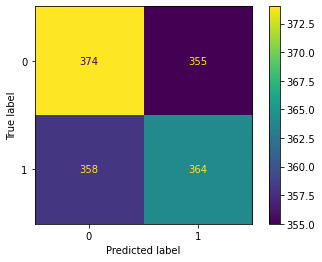

In [33]:
disp = cmd(confusion_matrix = cm, display_labels = xgb_best.classes_)
disp.plot()
plt.show

In [34]:
accuracy_score(y_test, best_preds) #Correct Predictions/Total Predictions

0.5086147484493453

In [35]:
precision_score(y_test, best_preds) #How many of the predicted home covers were correct

0.5062586926286509

In [36]:
recall_score(y_test, best_preds) #How many of all the home covers were we able to predict

0.5041551246537396